In [4]:
import os
import pandas as pd
import numpy as np
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [5]:
csv_dir = '../SEC Trackman Data/'
all_files = [os.path.join(csv_dir, f) for f in os.listdir(csv_dir) if f.endswith('.csv')]

df_list = []

for file in all_files:
    df = pd.read_csv(file)
    df_list.append(df)

all_pitches = pd.concat(df_list, ignore_index=True)

print(all_pitches.shape)
print(all_pitches.columns)

(270589, 167)
Index(['PitchNo', 'Date', 'Time', 'PAofInning', 'PitchofPA', 'Pitcher',
       'PitcherId', 'PitcherThrows', 'PitcherTeam', 'Batter',
       ...
       'ThrowTrajectoryZc1', 'ThrowTrajectoryZc2', 'PitchReleaseConfidence',
       'PitchLocationConfidence', 'PitchMovementConfidence',
       'HitLaunchConfidence', 'HitLandingConfidence',
       'CatcherThrowCatchConfidence', 'CatcherThrowReleaseConfidence',
       'CatcherThrowLocationConfidence'],
      dtype='object', length=167)


In [3]:
cfs = all_pitches[all_pitches['TaggedPitchType']=='Cutter']
print(cfs.shape)

(8203, 167)


In [6]:
cfs_rr = cfs[(cfs['PitcherThrows'] == 'Right') & (cfs['BatterSide'] == 'Right')]
cfs_rl = cfs[(cfs['PitcherThrows'] == 'Right') & (cfs['BatterSide'] == 'Left')]
cfs_lr = cfs[(cfs['PitcherThrows'] == 'Left') & (cfs['BatterSide'] == 'Right')]
cfs_ll = cfs[(cfs['PitcherThrows'] == 'Left') & (cfs['BatterSide'] == 'Left')]

print(cfs_rr.shape)
print(cfs_rl.shape)
print(cfs_lr.shape)
print(cfs_ll.shape)

(4522, 167)
(1976, 167)
(885, 167)
(805, 167)


In [7]:
cfs_rr['whiff'] = np.where(cfs_rr['PitchCall']=='StrikeSwinging',1,0)
cfs_rl['whiff'] = np.where(cfs_rl['PitchCall']=='StrikeSwinging',1,0)
cfs_lr['whiff'] = np.where(cfs_lr['PitchCall']=='StrikeSwinging',1,0)
cfs_ll['whiff'] = np.where(cfs_ll['PitchCall']=='StrikeSwinging',1,0)

C:\Users\charl\AppData\Local\Temp\ipykernel_17828\3511208490.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cfs_rr['whiff'] = np.where(cfs_rr['PitchCall']=='StrikeSwinging',1,0)
C:\Users\charl\AppData\Local\Temp\ipykernel_17828\3511208490.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cfs_rl['whiff'] = np.where(cfs_rl['PitchCall']=='StrikeSwinging',1,0)
C:\Users\charl\AppData\Local\Temp\ipykernel_17828\3511208490.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [8]:
preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']

In [9]:
cfs_rr_X = cfs_rr[preds]
cfs_rr_y = cfs_rr['whiff']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(cfs_rr_X, cfs_rr_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.52%


ROC AUC: 0.5230


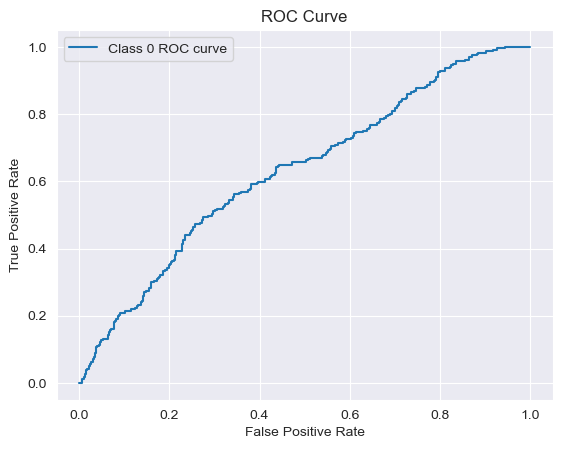

In [11]:
y_pred_prob = model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, predictions, multi_class='ovr')

print(f'ROC AUC: {roc_auc:.4f}')

# Plotting ROC Curve for one class (e.g., class 0)
fpr, tpr, _ = roc_curve(y_test == 1, y_pred_prob)
plt.plot(fpr, tpr, label='Class 0 ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [13]:
# Get unique values
unique_values = cfs_rr['Pitcher'].unique()

print(len(unique_values))

# Create a dictionary to store subsets
subsets = {value: cfs_rr[cfs_rr['Pitcher'] == value] for value in unique_values}

232


In [15]:
def rr_cfs_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(cfs_rr_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    return np.mean(stuff * 100)